In [1]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def multiunsqueeze(t, dims):
    if len(dims) == 0:
        return t
    else:
        return multiunsqueeze(t.unsqueeze(dims[0]), dims[1:])

In [5]:
edges = []
for i in range(10):
    for j in range(10):
        if i == j:
            continue
        if i < 5 and j >= 5:
            continue
        if i >= 5 and j < 5:
            continue
        edges.append([i, j, np.random.randint(1, 5)])
edges.append([5, 4, np.random.randint(1, 5)])
edges.append([4, 5, np.random.randint(1, 5)])
g = nx.DiGraph()
g.add_edges_from([(l[0], l[1]) for l in edges])
# g = nx.karate_club_graph()
# edges = list(g.to_directed().edges())
edges = torch.tensor(edges, requires_grad=False)

In [6]:
k = 3
assignments = torch.distributions.Categorical(logits=torch.randn(k)).sample([5, 10])
print("hello")
assignments

hello


tensor([[0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 2, 0, 0, 0, 0, 1],
        [0, 0, 0, 2, 1, 2, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 2, 1, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 0, 2]])

In [5]:
nnig = torch.sum(torch.nn.functional.one_hot(assignments), dim=-2)

In [6]:
z_tail = assignments[:, edges[:, 0]]  # Replace node id of tail with its group: (S, |E|)
z_head = assignments[:, edges[:, 1]]  # Replace node id of head with its group: (S, |E|)
z_head.shape, z_tail.shape

(torch.Size([5, 42]), torch.Size([5, 42]))

In [7]:
z_tail_one_hot = torch.unsqueeze(torch.nn.functional.one_hot(z_tail, k), -1).float()
z_head_one_hot = torch.unsqueeze(torch.nn.functional.one_hot(z_head, k), -2).float()
z_head_one_hot.shape, z_tail_one_hot.shape


(torch.Size([5, 42, 1, 3]), torch.Size([5, 42, 3, 1]))

In [9]:
multiunsqueeze(edges[:, -1], [-1, -1, -1]).shape

torch.Size([42, 1, 1, 1])

In [10]:
tmp =torch.matmul(z_tail_one_hot, z_head_one_hot) * multiunsqueeze(edges[:, -1], [-1, -1])
num_edges_btw_groups = torch.sum(tmp, dim=-3)

In [11]:
num_interactions = torch.matmul(nnig.unsqueeze(-1), nnig.unsqueeze(-2))

In [12]:
num_edges_btw_groups / torch.clamp_min(num_interactions, 1e-6)

tensor([[[0.9167, 1.5417,    nan],
         [1.1667, 0.5625,    nan],
         [   nan,    nan,    nan]],

        [[1.0370, 1.4444,    nan],
         [1.1111, 0.0000,    nan],
         [   nan,    nan,    nan]],

        [[0.9796, 1.2381,    nan],
         [1.3810, 0.4444,    nan],
         [   nan,    nan,    nan]],

        [[1.0000, 1.5714, 0.5714],
         [2.2857, 0.0000, 0.0000],
         [1.1429, 0.0000, 1.7500]],

        [[0.9844, 1.3125,    nan],
         [1.4375, 0.0000,    nan],
         [   nan,    nan,    nan]]])

In [3]:
x = torch.randint(0, 10, [14, 14]).float()
x

tensor([[5., 2., 8., 4., 8., 0., 7., 2., 7., 8., 2., 3., 0., 0.],
        [7., 0., 7., 8., 9., 5., 1., 4., 3., 5., 0., 4., 4., 1.],
        [6., 9., 1., 2., 6., 3., 8., 2., 9., 1., 5., 5., 3., 3.],
        [8., 4., 8., 0., 6., 5., 8., 2., 8., 7., 9., 1., 1., 9.],
        [0., 7., 0., 7., 7., 0., 5., 0., 3., 5., 1., 4., 5., 3.],
        [6., 5., 3., 6., 1., 1., 9., 3., 1., 8., 1., 3., 3., 7.],
        [2., 5., 8., 1., 1., 8., 9., 5., 1., 1., 0., 0., 8., 4.],
        [6., 1., 9., 2., 2., 5., 8., 2., 6., 2., 2., 8., 6., 0.],
        [1., 8., 1., 5., 4., 5., 4., 7., 9., 5., 7., 6., 0., 5.],
        [0., 3., 1., 9., 3., 2., 5., 6., 3., 1., 4., 2., 8., 0.],
        [7., 2., 5., 7., 3., 4., 1., 9., 1., 4., 4., 8., 2., 4.],
        [1., 6., 8., 9., 6., 9., 4., 0., 2., 4., 9., 6., 6., 7.],
        [0., 6., 9., 1., 8., 7., 5., 8., 6., 9., 2., 3., 1., 0.],
        [6., 9., 7., 1., 2., 2., 7., 2., 8., 0., 1., 8., 9., 6.]])

In [5]:
d = torch.distributions.Normal(torch.zeros(14), torch.ones(14) * 3)
tmp = torch.exp(d.log_prob(x))
tmp / torch.sum(tmp, dim=-1, keepdim=True)

tensor([[0.0362, 0.1163, 0.0041, 0.0597, 0.0041, 0.1452, 0.0095, 0.1163, 0.0095,
         0.0041, 0.1163, 0.0881, 0.1452, 0.1452],
        [0.0103, 0.1562, 0.0103, 0.0045, 0.0017, 0.0390, 0.1478, 0.0642, 0.0947,
         0.0390, 0.1562, 0.0642, 0.0642, 0.1478],
        [0.0221, 0.0018, 0.1542, 0.1306, 0.0221, 0.0989, 0.0047, 0.1306, 0.0018,
         0.1542, 0.0407, 0.0407, 0.0989, 0.0989],
        [0.0061, 0.0876, 0.0061, 0.2132, 0.0289, 0.0532, 0.0061, 0.1707, 0.0061,
         0.0140, 0.0024, 0.2017, 0.2017, 0.0024],
        [0.1331, 0.0087, 0.1331, 0.0087, 0.0087, 0.1331, 0.0332, 0.1331, 0.0807,
         0.0332, 0.1259, 0.0547, 0.0332, 0.0807],
        [0.0198, 0.0365, 0.0887, 0.0198, 0.1384, 0.1384, 0.0016, 0.0887, 0.1384,
         0.0042, 0.1384, 0.0887, 0.0887, 0.0096],
        [0.1055, 0.0328, 0.0038, 0.1246, 0.1246, 0.0038, 0.0015, 0.0328, 0.1246,
         0.1246, 0.1317, 0.1317, 0.0038, 0.0542],
        [0.0203, 0.1418, 0.0017, 0.1200, 0.1200, 0.0374, 0.0043, 0.1200, 0.0203,
  

In [34]:
i = 0
j = 1
x = torch.randn(3, 5, 2)
tmp = x.unsqueeze(2) * x.unsqueeze(1)
print(tmp.shape)
tmp[0, i, j, ...]

torch.Size([3, 5, 5, 2])


tensor([-0.1200, -0.2127])

In [35]:
np.array([
    [x[0, i, 0] * x[0, j, 0], x[0, i, 1] * x[0, j, 1]],
])

array([[-0.12002105, -0.2127365 ]], dtype=float32)

-0.011


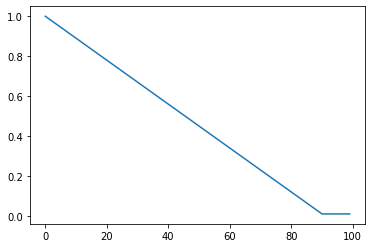

In [18]:
ax = plt.subplot()
num_iter = 100.
fraction = 0.9
target_scale = 0.01
stop = num_iter * fraction

m = (target_scale - 1.) / stop
print(m)
ax.plot(np.arange(100), np.clip(np.arange(100) * m + 1, target_scale, 1))


In [12]:
g = nx.karate_club_graph()
nx.spring_layout(g)


{0: array([-0.01460818,  0.40473946]),
 1: array([-0.06436423,  0.26865159]),
 2: array([-0.15628947, -0.00870772]),
 3: array([-0.22047697,  0.31936139]),
 4: array([0.21302039, 0.68218242]),
 5: array([0.26968004, 0.83445865]),
 6: array([0.3600123 , 0.73612493]),
 7: array([-0.30599004,  0.26147338]),
 8: array([ 0.08030072, -0.05406208]),
 9: array([-0.35968397, -0.23151199]),
 10: array([0.09538218, 0.80892633]),
 11: array([-0.18886245,  0.82984821]),
 12: array([-0.36963777,  0.55474491]),
 13: array([-0.02279513,  0.12145985]),
 14: array([ 0.40231372, -0.35537424]),
 15: array([ 0.38387447, -0.47774808]),
 16: array([0.5216451, 1.       ]),
 17: array([-0.19901323,  0.58174268]),
 18: array([ 0.36110351, -0.59437158]),
 19: array([0.00042951, 0.04733978]),
 20: array([ 0.08748208, -0.61818179]),
 21: array([-0.01992822,  0.58778742]),
 22: array([ 0.25482547, -0.65744571]),
 23: array([-0.14150499, -0.601966  ]),
 24: array([-0.38609132, -0.58464402]),
 25: array([-0.45353916,